# Arbitrary Neural Artistic Stylization
There are a lot of ways that we can look at art and images with neural networks, but can we use those networks to make art for us?  Yes.  Yes we can, and it's not too difficult.

The contents of this notebook allow for the user to upload two images (or use the ones here from Unsplash).  The model will learn the style of the style image and try to recreate the content image using those stylistic attributes.  The result is pure art.  The model used here was developed by Magenta and a writeup on the general structure of the model can be found here: https://arxiv.org/abs/1705.06830

# 1- Start here: enter the locations for the content and style images

### Content Image: 
Choose a content image with path.

In [1]:
content_file_name = 'cmonster' # enter a new and unique name.  This is saved in your files.
content_location = 'https://cjmart.jp/en/upload/save_image/0050_1601024_s8t4f6_y_3.jpg'

### Style Image: 
Choose a style image with path.

In [2]:
style_file_name = 'abstract01' # enter a new and unique name.  This is saved in your files.
style_location = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/energized--abstract-art-by-fidostudio-tom-fedro--fidostudio.jpg'

# 2- Make the model

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
import IPython.display as display
import requests

# Un-hash the next two lines if you need to install tensorflow_hub
# import sys
# !{sys.executable} -m pip install tensorflow_hub
import tensorflow_hub as hub

# Massage the images to be the right shape, size and type.
def load_img(path_to_img):
  max_dim = 1024
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# Create an image from an array
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Look at the images
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

In [4]:
# Hash this out if you prefer CPU usage
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

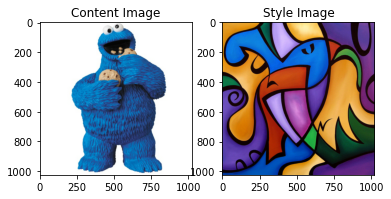

In [5]:
# Get the images
content_path = tf.keras.utils.get_file(content_file_name, content_location)
style_path = tf.keras.utils.get_file(style_file_name, style_location)

# Massage in the images
content_image = load_img(content_path)
style_image = load_img(style_path)

# Take a look at the images
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.savefig('cookieStyle.png')

# 3- Get the results

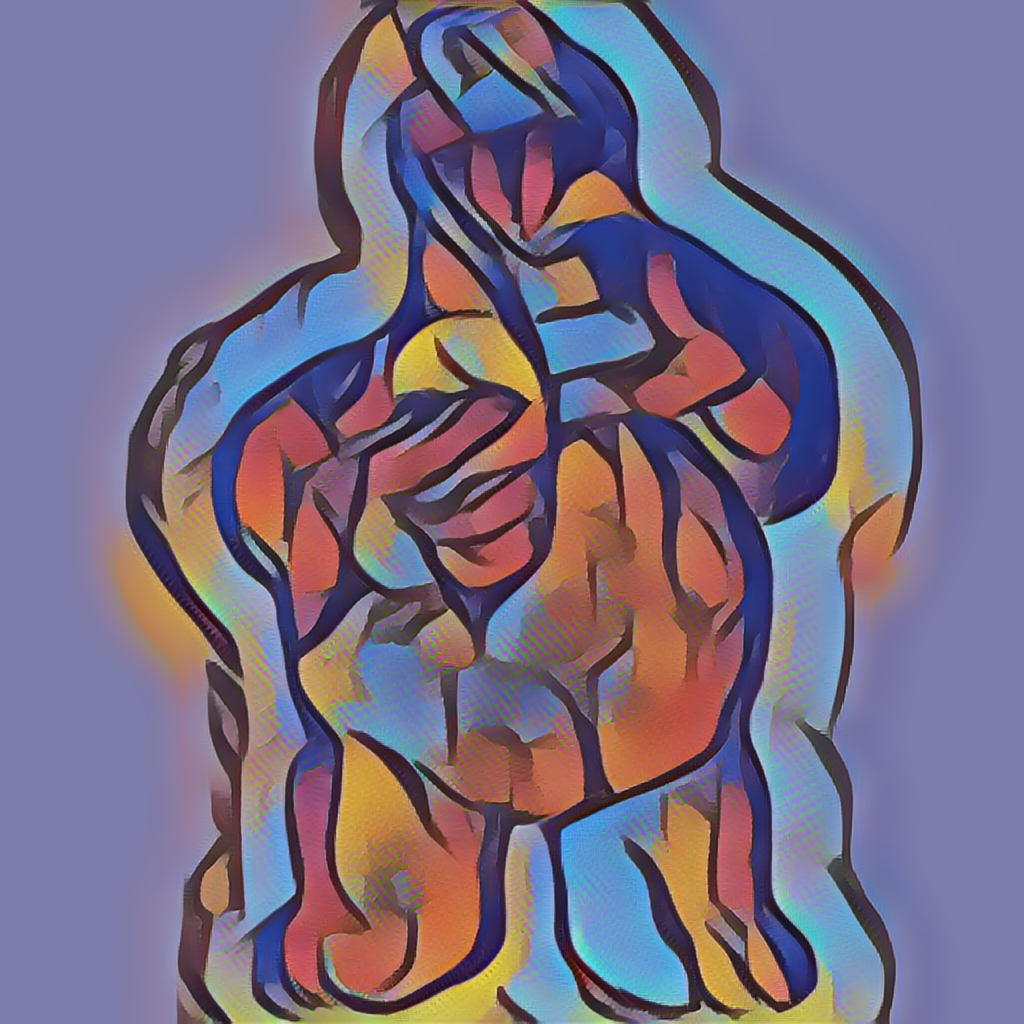

In [6]:
# Get the model and create the stylized image
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

#Take a look at the stylized image
arb_img = tensor_to_image(stylized_image)
display.display(arb_img)

#Save the stylized image
arb_name = str(content_file_name + "_arb.png")
arb_img.save(arb_name)

In [7]:
# Create a high-res image.  This API has call-limits, so use a VPN for best results or create an account.
r = requests.post(
    "https://api.deepai.org/api/torch-srgan",
    files={
        'image': open(arb_name, 'rb'),
    },
    headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
)
print(r.json())

{'id': '3c0a1ae3-00e7-4fea-baf9-30d490238fed', 'output_url': 'https://api.deepai.org/job-view-file/3c0a1ae3-00e7-4fea-baf9-30d490238fed/outputs/output.jpg'}


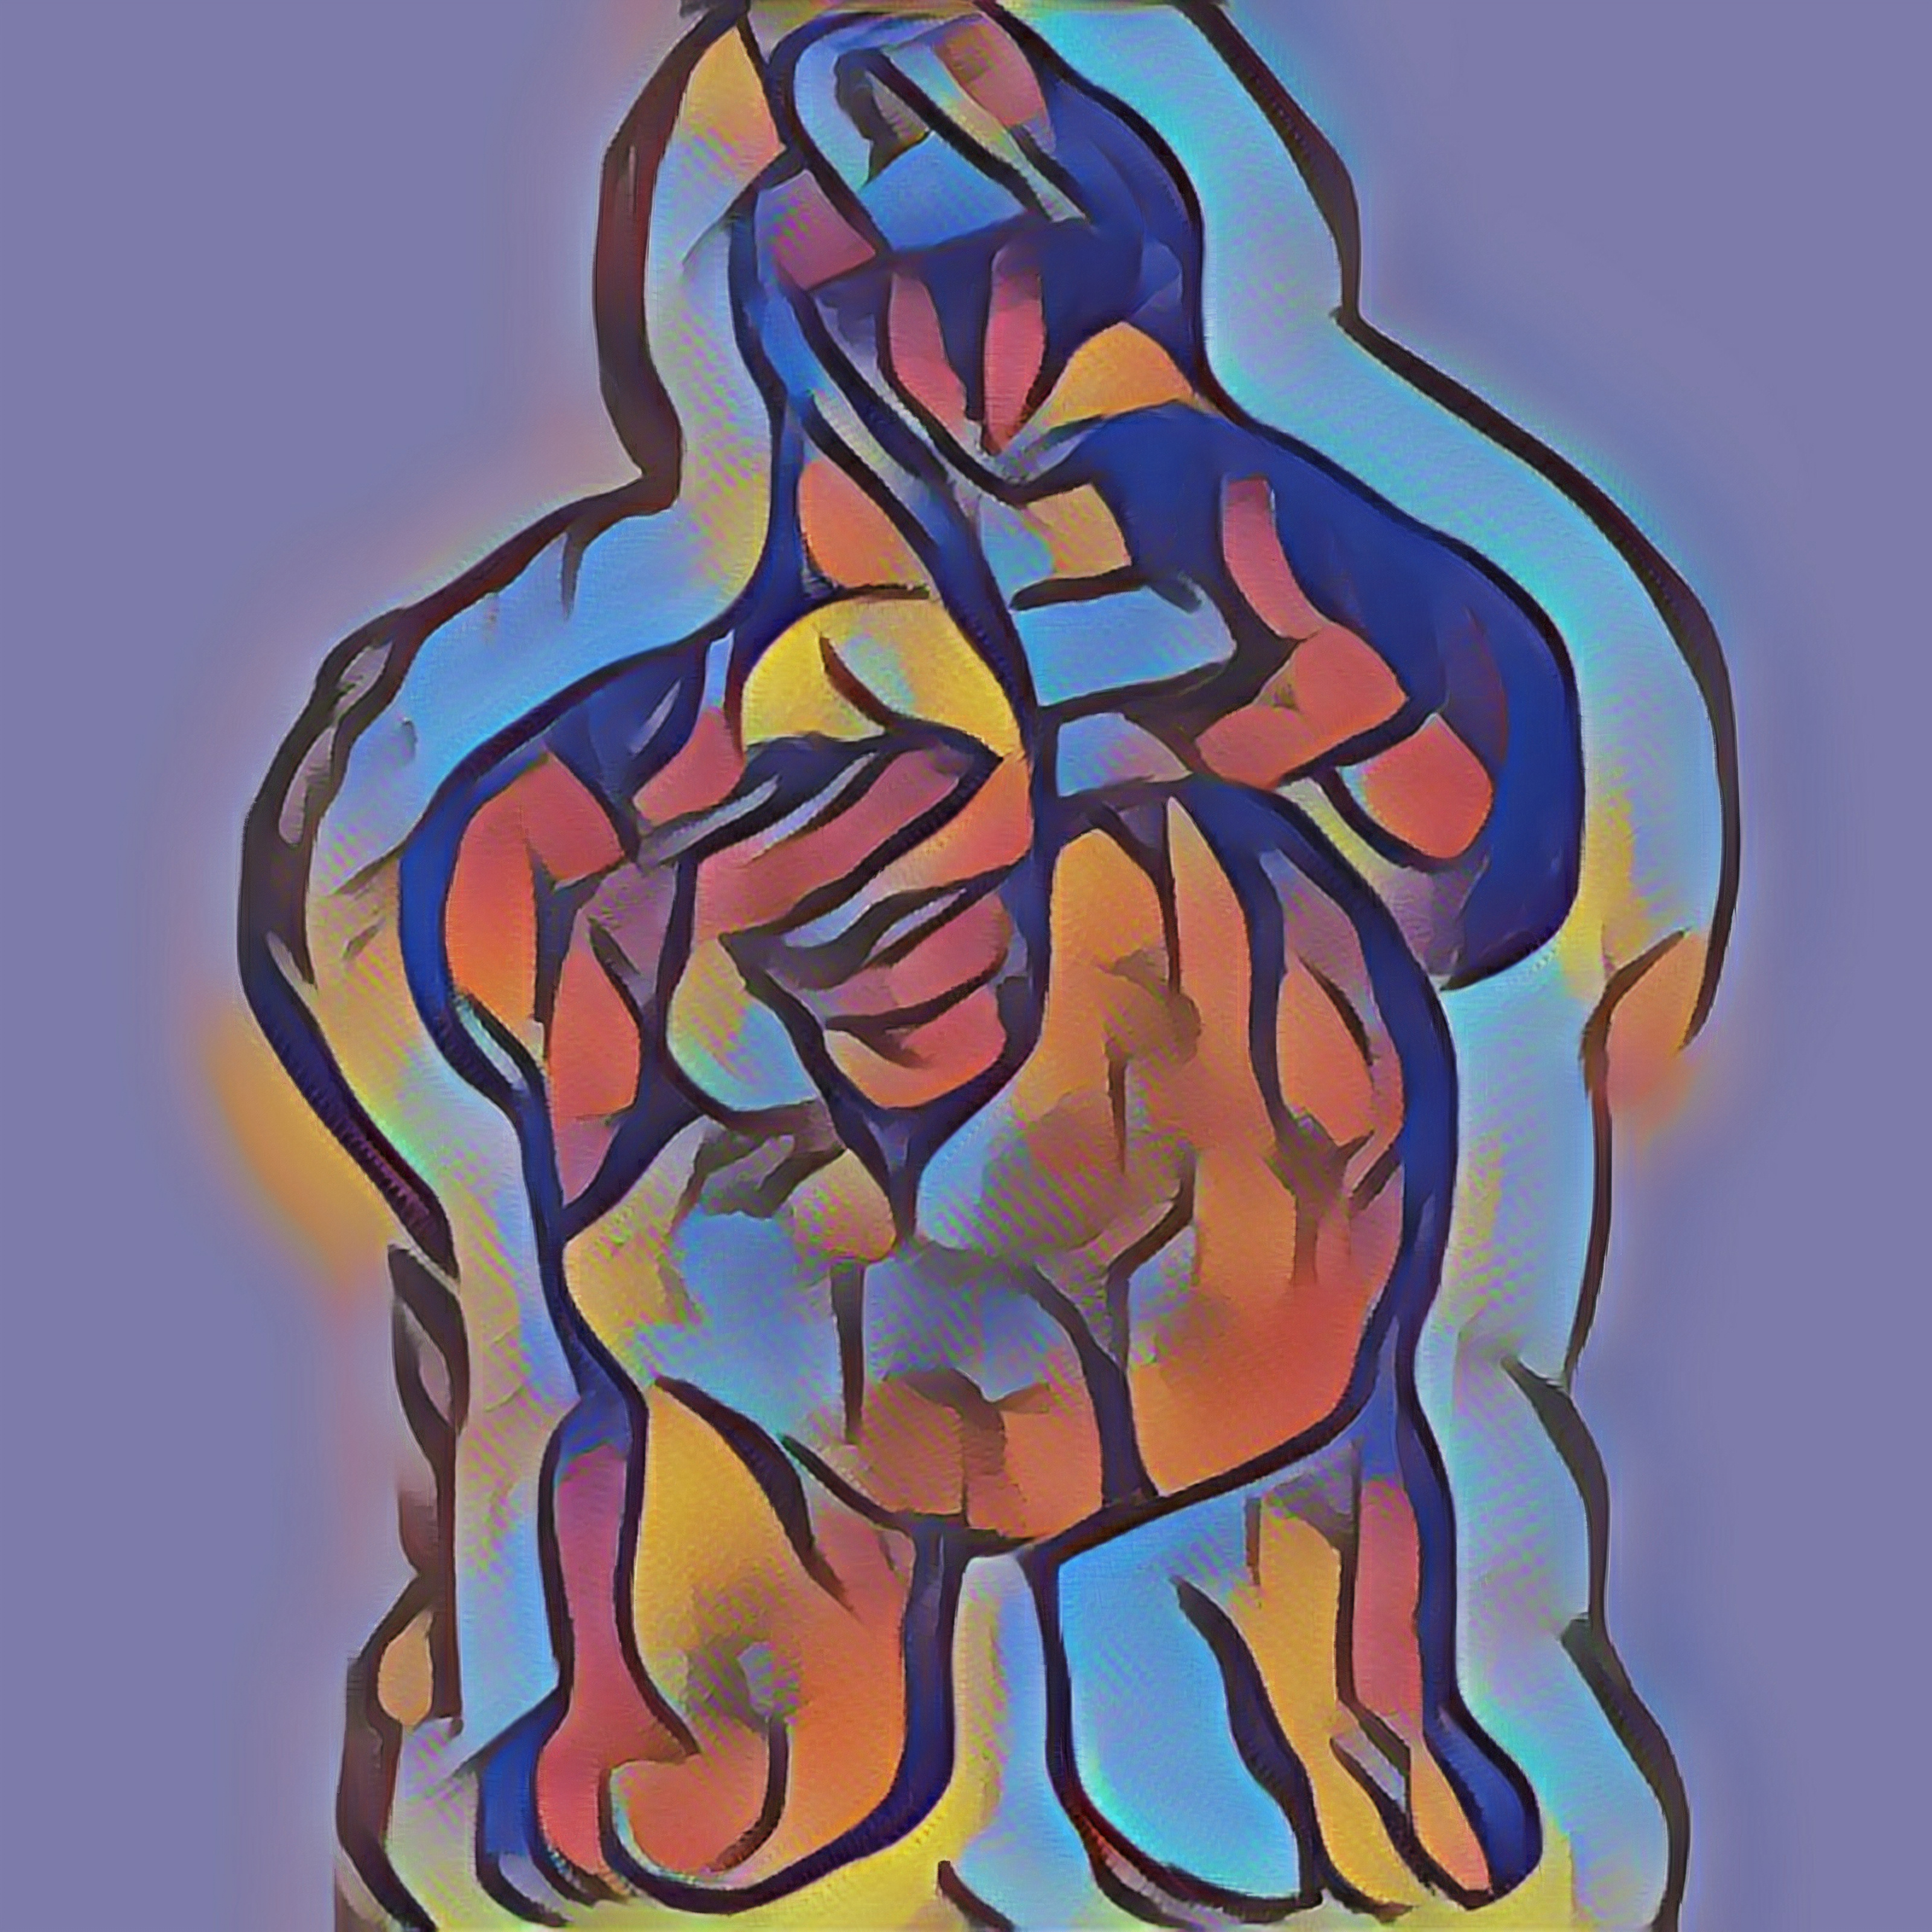

In [8]:
# Get the API image and display it
url = r.json()['output_url']
sr_img = requests.get(url).content
display.Image(sr_img)

In [9]:
# Save the high-res image
with open(str(content_file_name + "_arb_SR.jpg"), "wb") as png:
    png.write(sr_img)